
# **Opioid Overdose Risk Model – Training Notebook**

# Step 01 : Importing necessary libraries

In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    brier_score_loss,
    classification_report,
)
from sklearn.model_selection import train_test_split

import joblib
import matplotlib.pyplot as plt


# Step 02 : Load the Dataset (opioid_dataset.csv)

In [ ]:

import pandas as pd

# Load dataset (previously downloaded)
df = pd.read_csv("opioid_dataset.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (400, 25)


,age,gender,weight_kg,height_cm,has_chronic_pain,has_mental_health_dx,history_of_substance_abuse,liver_disease,kidney_disease,respiratory_disease,...,concurrent_sleep_meds,concurrent_antidepressants,alcohol_use,tobacco_use,previous_overdose,daily_mme,risk_factors_count,overdose_risk_label,risk_percentage,overdose_risk_class
0,86,Female,56,167,1,0,1,0,0,0,...,0,0,Light,0,0,158.0,2,0.636782,63.678188,1
1,52,Male,45,168,0,0,0,0,0,1,...,1,0,Moderate,1,0,3.0,3,0.160708,16.070839,0
2,64,Male,60,171,1,0,1,0,0,1,...,0,0,NaN,0,0,76.0,3,0.383598,38.359777,0
3,35,Female,79,162,0,0,1,0,0,0,...,0,0,Light,1,0,47.0,3,0.279145,27.914493,0
4,73,Female,64,176,1,0,1,0,1,1,...,0,0,NaN,0,0,18100.0,4,0.999000,99.900000,1


# Step 03 :
# Inspect distribution of overdose risk, MME, and risk factors


=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          400 non-null    int64  
 1   gender                       400 non-null    object 
 2   weight_kg                    400 non-null    int64  
 3   height_cm                    400 non-null    int64  
 4   has_chronic_pain             400 non-null    int64  
 5   has_mental_health_dx         400 non-null    int64  
 6   history_of_substance_abuse   400 non-null    int64  
 7   liver_disease                400 non-null    int64  
 8   kidney_disease               400 non-null    int64  
 9   respiratory_disease          400 non-null    int64  
 10  primary_opioid               400 non-null    object 
 11  daily_dosage_mg              400 non-null    float64
 12  treatment_duration_months    400 non-null    int64  
 13  

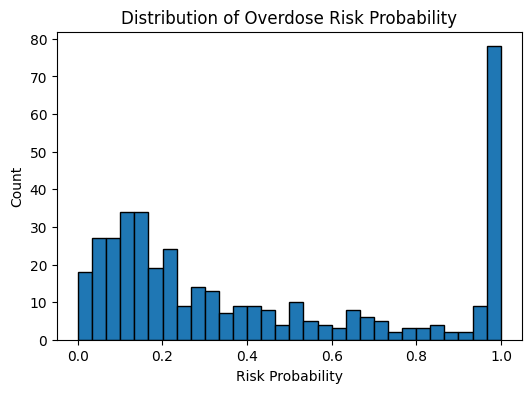

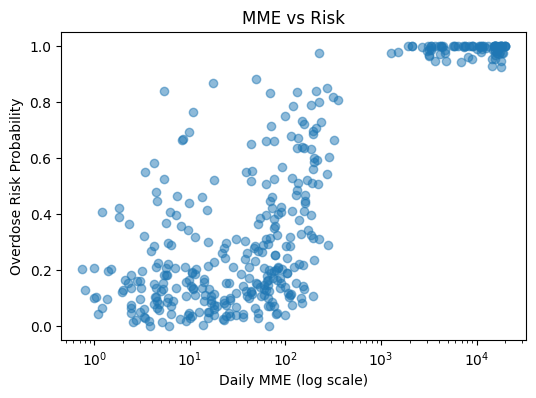

In [4]:

# %%
print("\n=== Basic Info ===")
print(df.info())

print("\n=== Risk label stats (probability 0–1) ===")
print(df["overdose_risk_label"].describe())

print("\n=== Binary class distribution (0 = low, 1 = high) ===")
print(df["overdose_risk_class"].value_counts(normalize=True))

print("\n=== Daily MME summary ===")
print(df["daily_mme"].describe())

print("\nSample rows with low MME & low risk factors:")
low_cases = df[df["daily_mme"] < 50].sort_values("daily_mme").head(10)[
    ["daily_mme", "risk_factors_count", "overdose_risk_label"]
]
print(low_cases)

print("\nSample rows with very high MME:")
high_cases = df[df["daily_mme"] > 1000].sort_values("daily_mme").head(10)[
    ["daily_mme", "risk_factors_count", "overdose_risk_label"]
]
# %%
import matplotlib.pyplot as plt

print("\n=== Basic Info ===")
print(df.info())

print("\n=== Risk label stats (probability 0–1) ===")
print(df["overdose_risk_label"].describe())

print("\n=== Binary class distribution (0 = low, 1 = high) ===")
print(df["overdose_risk_class"].value_counts(normalize=True))

print("\n=== Daily MME summary ===")
print(df["daily_mme"].describe())

print("\nSample rows with low MME & low risk factors:")
low_cases = df[df["daily_mme"] < 50].sort_values("daily_mme").head(10)[
    ["daily_mme", "risk_factors_count", "overdose_risk_label"]
]
print(low_cases)

print("\nSample rows with very high MME:")
high_cases = df[df["daily_mme"] > 1000].sort_values("daily_mme").head(10)[
    ["daily_mme", "risk_factors_count", "overdose_risk_label"]
]
print(high_cases)
plt.figure(figsize=(6,4))
plt.hist(df["overdose_risk_label"], bins=30, edgecolor="k")
plt.title("Distribution of Overdose Risk Probability")
plt.xlabel("Risk Probability")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["daily_mme"], df["overdose_risk_label"], alpha=0.5)
plt.xscale("log")
plt.xlabel("Daily MME (log scale)")
plt.ylabel("Overdose Risk Probability")
plt.title("MME vs Risk")
plt.show()


# 5 : Preprocessing: encode categoricals, build feature matrix, scale

In [9]:
# 5. Preprocessing: encode categoricals, build feature matrix, scale

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Categorical columns to encode
cat_cols = ["gender", "primary_opioid", "alcohol_use"]

label_encoders = {}
df_encoded = df.copy()

# Encode categoricals (used later by backend)
for col in cat_cols:
    le = LabelEncoder()
    cleaned = df_encoded[col].astype(str).replace("nan", "None")
    df_encoded[f"{col}_encoded"] = le.fit_transform(cleaned)
    label_encoders[col] = le

# Drop original categoricals
df_encoded = df_encoded.drop(columns=cat_cols)

# Feature order (must match backend)
feature_names = [
    "age",
    "weight_kg",
    "height_cm",
    "has_chronic_pain",
    "has_mental_health_dx",
    "history_of_substance_abuse",
    "liver_disease",
    "kidney_disease",
    "respiratory_disease",
    "daily_dosage_mg",
    "treatment_duration_months",
    "concurrent_benzos",
    "concurrent_muscle_relaxants",
    "concurrent_sleep_meds",
    "concurrent_antidepressants",
    "tobacco_use",
    "previous_overdose",
    "daily_mme",
    "risk_factors_count",
    "gender_encoded",
    "primary_opioid_encoded",
    "alcohol_use_encoded",
]

X = df_encoded[feature_names].copy()

# Ensure numeric
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

# Target
y = df["overdose_risk_class"].astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X shape: (400, 22)
y shape: (400,)


# 6. Train Logistic Regression (probability output)

In [ ]:
# 6. Train Logistic Regression (probability output)

log_reg = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)

log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)

print("=== Logistic Regression Performance ===")
print(f"Accuracy    : {acc:.3f}")
print(f"ROC AUC     : {auc:.3f}")
print(f"Brier Score : {brier:.3f}\n")

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))


=== Logistic Regression Performance ===
Accuracy    : 0.910
ROC AUC     : 0.967
Brier Score : 0.074

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        64
           1       0.89      0.86      0.87        36

    accuracy                           0.91       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.91      0.91      0.91       100



# 7. Save model + scaler + label encoders for backend (ml_model.py)

In [ ]:
# 7. Save model + scaler + label encoders for backend (ml_model.py)

output_dir = Path('backend\ ml_model')
output_dir.mkdir(parents=True, exist_ok=True)

best_model_path = output_dir / "best_model.pkl"
scaler_path = output_dir / "scaler.pkl"
encoders_path = output_dir / "label_encoders.pkl"

joblib.dump(log_reg, best_model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoders, encoders_path)

print("Saved:")
print("  best_model.pkl ->", best_model_path)
print("  scaler.pkl     ->", scaler_path)
print("  label_encoders.pkl ->", encoders_path)

Saved:
  best_model.pkl -> backend\ml_model\best_model.pkl
  scaler.pkl     -> backend\ml_model\scaler.pkl
  label_encoders.pkl -> backend\ml_model\label_encoders.pkl


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\pvina\AppData\Local\Temp\ipykernel_4536\22809192.py:5: SyntaxWarning: invalid escape sequence '\m'
  output_dir = Path('backend\ml_model')


# 8. Sanity-check predictions on a few test cases

In [ ]:
# 8. Sanity-check predictions on a few synthetic constructed cases

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def print_example_case(desc, patient_dict):
    """
    patient_dict should match your backend model_input keys before encoding.
    """
    # Build a DataFrame with a single row using same preprocessing as ml_model.py
    temp = pd.DataFrame([patient_dict])

    # Fill missing categorical with 'None' for encoder consistency
    for c in ["gender", "primary_opioid", "alcohol_use"]:
        temp[c] = temp.get(c, "None").astype(str).replace("nan", "None")

    # Apply label encoders
    for col, le in label_encoders.items():
        temp[col] = temp[col].astype(str)
        # unseen classes: add then transform
        for label in temp[col].unique():
            if label not in le.classes_:
                le.classes_ = np.append(le.classes_, label)
        temp[f"{col}_encoded"] = le.transform(temp[col])

    # Drop original cat columns
    temp = temp.drop(columns=["gender", "primary_opioid", "alcohol_use"], errors="ignore")

    # Ensure all feature columns exist
    for f in feature_names:
        if f not in temp.columns:
            temp[f] = 0

    temp = temp[feature_names]
    for col in temp.columns:
        temp[col] = pd.to_numeric(temp[col], errors="coerce").fillna(0)

    temp_scaled = scaler.transform(temp)
    proba = log_reg.predict_proba(temp_scaled)[0, 1]

    print(f"\n{desc}")
    print("Input:", patient_dict)
    print(f"Predicted overdose risk probability: {proba:.4f} ({proba*100:.1f}%)")


# Example 1: low-risk case
print_example_case(
    "Low-dose codeine, no major risk factors",
    {
        "age": 30,
        "weight_kg": 70,
        "height_cm": 170,
        "has_chronic_pain": 1,
        "has_mental_health_dx": 0,
        "history_of_substance_abuse": 0,
        "liver_disease": 0,
        "kidney_disease": 0,
        "respiratory_disease": 0,
        "daily_dosage_mg": 10,
        "treatment_duration_months": 3,
        "concurrent_benzos": 0,
        "concurrent_muscle_relaxants": 0,
        "concurrent_sleep_meds": 0,
        "concurrent_antidepressants": 0,
        "tobacco_use": 0,
        "previous_overdose": 0,
        "daily_mme": 1.5,
        "risk_factors_count": 1,
        "gender": "Male",
        "primary_opioid": "Codeine",
        "alcohol_use": "None",
    },
)

# Example 2: extreme-risk case like your Fentanyl 50mg x2, multiple comorbidities
print_example_case(
    "Very high-dose Fentanyl, multiple risk factors",
    {
        "age": 65,
        "weight_kg": 60,
        "height_cm": 165,
        "has_chronic_pain": 1,
        "has_mental_health_dx": 1,
        "history_of_substance_abuse": 1,
        "liver_disease": 1,
        "kidney_disease": 1,
        "respiratory_disease": 1,
        "daily_dosage_mg": 100,   # 50mg twice
        "treatment_duration_months": 24,
        "concurrent_benzos": 1,
        "concurrent_muscle_relaxants": 0,
        "concurrent_sleep_meds": 1,
        "concurrent_antidepressants": 1,
        "tobacco_use": 1,
        "previous_overdose": 1,
        "daily_mme": 100 * 100.0,  # Fentanyl factor
        "risk_factors_count": 9,   # approx sum of booleans above
        "gender": "Male",
        "primary_opioid": "Fentanyl",
        "alcohol_use": "Heavy",
    },
)



Low-dose codeine, no major risk factors
Input: {'age': 30, 'weight_kg': 70, 'height_cm': 170, 'has_chronic_pain': 1, 'has_mental_health_dx': 0, 'history_of_substance_abuse': 0, 'liver_disease': 0, 'kidney_disease': 0, 'respiratory_disease': 0, 'daily_dosage_mg': 10, 'treatment_duration_months': 3, 'concurrent_benzos': 0, 'concurrent_muscle_relaxants': 0, 'concurrent_sleep_meds': 0, 'concurrent_antidepressants': 0, 'tobacco_use': 0, 'previous_overdose': 0, 'daily_mme': 1.5, 'risk_factors_count': 1, 'gender': 'Male', 'primary_opioid': 'Codeine', 'alcohol_use': 'None'}
Predicted overdose risk probability: 0.0033 (0.3%)

Very high-dose Fentanyl, multiple risk factors
Input: {'age': 65, 'weight_kg': 60, 'height_cm': 165, 'has_chronic_pain': 1, 'has_mental_health_dx': 1, 'history_of_substance_abuse': 1, 'liver_disease': 1, 'kidney_disease': 1, 'respiratory_disease': 1, 'daily_dosage_mg': 100, 'treatment_duration_months': 24, 'concurrent_benzos': 1, 'concurrent_muscle_relaxants': 0, 'concurr